In [1]:
#Bayesian inference on a pure birth process 0-->X-->0 with discrete observations
#Here we assume that the number of birth and death reactions are continuous by taking continuous priors. 

#In the case where we define them as discrete, specifying step= pm.NUTS automatically adjusts the sampler to Metropolis-Hastings
#for the reaction numbers and takes HMC for the parameters. 


import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import theano.tensor as tt
import theano as T
import pandas as pd

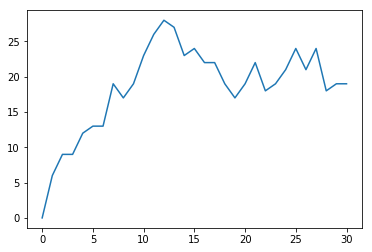

In [2]:
#generate data
trueA = 5.0
trueB = 0.2
N=30              #end of observation time in the subsampling
nt = 3000          #number of reactions to simulate
y=np.zeros(nt+1)     #complete data
x=np.zeros(N+1)    #subsampled data
t=np.zeros(nt+1)     #time
y[0]=0             
t[0]=0
v=np.array([1, -1])            #reaction vectors
#Perform SSA
for i in range(nt):
    a=np.array([trueA, trueB*y[i]] )
    sum_a=np.sum(a)
    cumsum_a=np.cumsum(a,axis=0)
    epsilon=np.random.uniform(0,1,2)
    dummy=len(cumsum_a)-1
    for k in range(2):
        if cumsum_a[k]>epsilon[0]*sum_a and k<=dummy:
            dummy=k 
    j=dummy               
    tau=(np.log(1/epsilon[1]))/sum_a
    y[i+1]=y[i]+v[j]
    t[i+1]=t[i]+tau
    
#subsample the trajectory on unit intervals
x[0]=y[0]
for i in range(1,N+1):
        for k in range(1,nt): 
            if t[k]>i-1 and t[k]<i:
                x[i]=y[k]; 
plt.plot(x)
plt.show()                

In [ ]:
#x=pd.read_csv("subsampled_narrow.csv").values
#x=np.load('x.npy')
#N=len(x)-1

In [4]:
div=1
r_idx=np.arange(N)
x_ave=np.zeros(N)
x_dif=np.zeros(N)
Ashape = 5/div
Arate = 1
Bshape = 0.2/div
Brate = 1
for i in range(N):
    x_ave[i]=0.5*(x[i]+x[i+1])
    x_dif[i]=x[i+1]-x[i]

In [5]:
#Custom likelihoods and other functions
def fact(x):    #usual factorial function doesn't work on tensors
    k=tt.gamma(x + 1)
    return k

def Pois_pmf(l,x):
    k=(l**x)*np.exp(-l)/fact(x)
    return k
    
def likelihood(A,B,r_birth,r_death,mu_death,N,div):
    k=1
    d=tt.switch(tt.le(r_death,0),0,1)
    for i in range(N):  
        factor=Pois_pmf(A/div,r_birth[i])*Pois_pmf(mu_death[i],r_death[i])*d[i]  #try to change to loglikelihood
        #factor=Pois_pmf(A/div,r_birth[i])*Pois_pmf(mu_death[i],r_death[i])
        #factor=np.log(Pois_pmf(A/div,r_birth[i]))+np.log(Pois_pmf(mu_death[i],r_death[i]))
        k*=factor
    return k

In [6]:
basic_model = pm.Model()

with basic_model: 
    #priors
    A = pm.Gamma('A', alpha=Ashape, beta=Arate )
    B = pm.Gamma('B', alpha=Bshape, beta=Brate )
    #r_birth = pm.Poisson('r_birth', mu= A,shape=N) 
    r_birth = pm.Uniform('r_birth', lower=0, upper=2*A, shape=N)
    r_death = pm.Deterministic('r_death',r_birth-x_dif)
    mu_death = B*x_ave/div 
    
    #likelihood    
    like= pm.Potential('like', likelihood(A,B,r_birth,r_death,mu_death,N,div))
    
    #instantiate sample
    step = pm.NUTS()
    trace = pm.sample(2000,step=step, tune=3500)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r_birth, B, A]
Sampling 4 chains: 100%|██████████| 22000/22000 [04:00<00:00, 91.41draws/s] 
There were 202 divergences after tuning. Increase `target_accept` or reparameterize.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
There were 204 divergences after tuning. Increase `target_accept` or reparameterize.
There were 121 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027F3C244F98>,
      dtype=object)

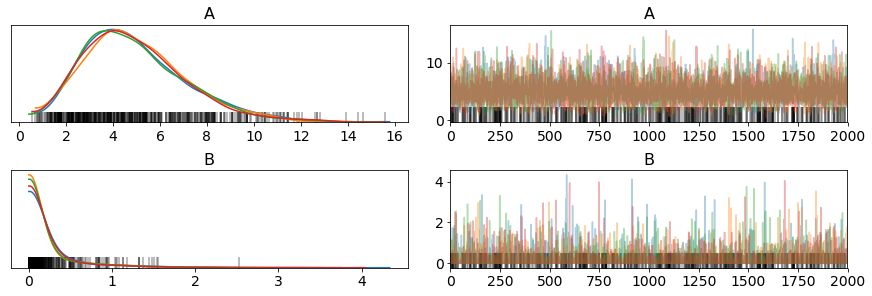

In [7]:
pm.traceplot(trace, var_names=['A','B'])

In [8]:
pm.summary(trace, var_names=['A','B'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
A,4.950041,2.189002,0.024033,1.215608e+00,9.286931,8819.429597,1.000021
B,0.194906,0.418603,0.005141,6.875883e-20,1.055323,6839.964491,1.000226


In [ ]:
pm.traceplot(trace, var_names='r_birth')

In [ ]:
pm.traceplot(trace, var_names='r_death')